# ADF for binary logistic regression

In [28]:
import jax
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import random

from sklearn.datasets import make_biclusters
import blackjax.rwmh as mh

In [29]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["figure.figsize"] = (5, 3)

In [430]:
def sigmoid(z): return jnp.exp(z) / (1 + jnp.exp(z))
def log_sigmoid(z): return z - jnp.log(1 + jnp.exp(z))

def inference_loop(rng_key, kernel, initial_state, num_samples):
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

## The data

In [472]:
n_datapoints = 50
m = 2
X, rows, cols = make_biclusters((n_datapoints, m), 2, noise=0.6, random_state=314, minval=-3, maxval=3)
# whether datapoints belong to class 1
y = rows[0] * 1.0

Phi = jnp.c_[jnp.ones(n_datapoints)[:, None], X]
N, M = Phi.shape

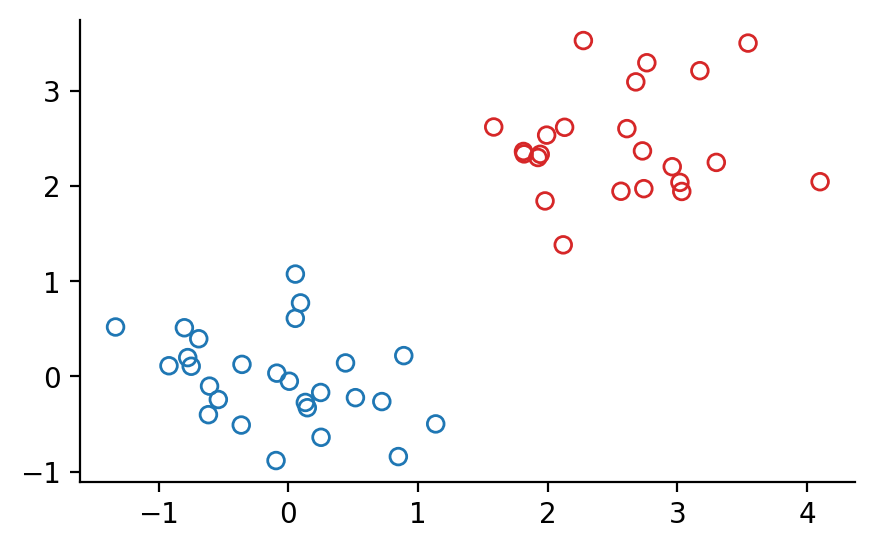

In [473]:
colors = ["tab:red" if el else "tab:blue" for el in rows[0]]
plt.scatter(*X.T, edgecolors=colors, c="none")
plt.show()

## MCMC Sampling

In [481]:
key = random.PRNGKey(314)
init_noise = 1.0
w0 = random.multivariate_normal(key, jnp.zeros(M), jnp.eye(M) * init_noise)

In [492]:
jnp.maximum(0, jnp.array([0.1, -0.1]))

DeviceArray([0.1, 0. ], dtype=float32)

In [495]:
alpha = 1.0
def E(w):
    log_an = log_sigmoid(Phi @ w)
    an = Phi @ w
    log_likelihood_term = y * log_an + (1 - y) * jnp.log(1 - sigmoid(an))
    prior_term = alpha * w @ w / 2

    return prior_term - log_likelihood_term.sum()

In [496]:
sigma_mcmc = 0.7
initial_state = mh.new_state(w0, E)

mcmc_kernel = mh.kernel(E, jnp.ones(M) * sigma_mcmc)
mcmc_kernel = jax.jit(mcmc_kernel)

key_init = jax.random.PRNGKey(0)
states = inference_loop(key_init, mcmc_kernel, initial_state, 5_000)

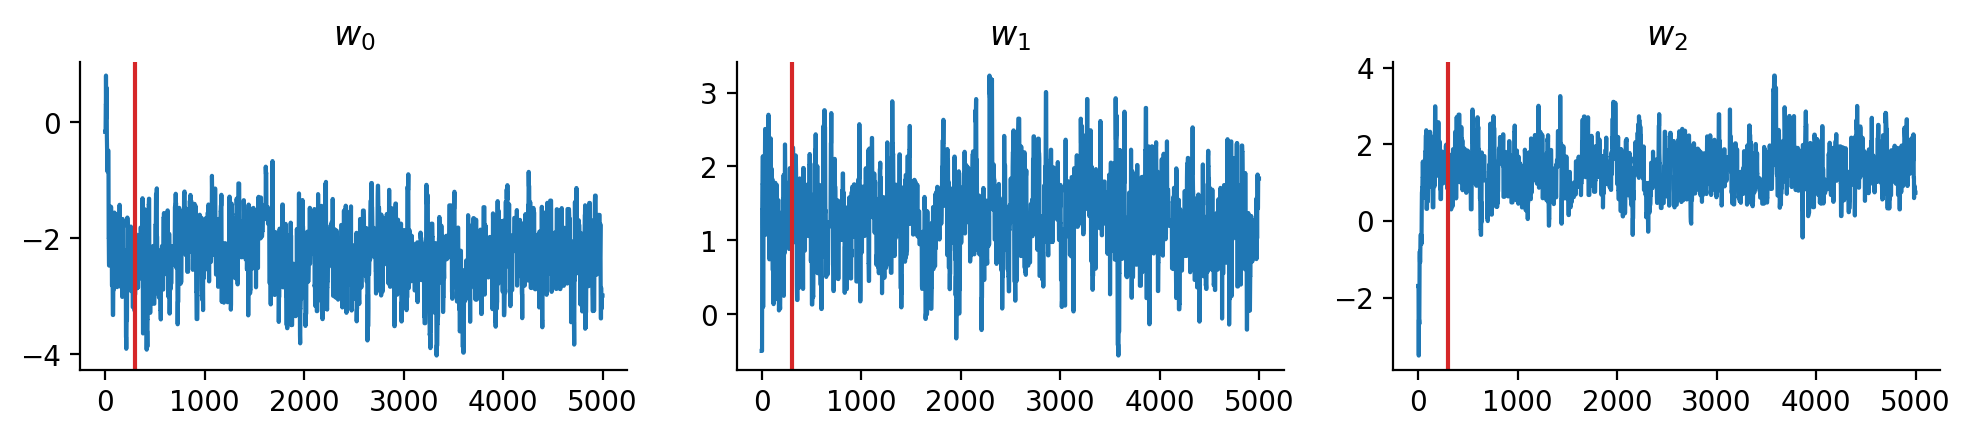

In [497]:
burnout = 300

fig, ax = plt.subplots(1, 3, figsize=(12, 2))
for i, axi in enumerate(ax):
    axi.plot(states.position[:, i])
    axi.set_title(f"$w_{i}$")
    axi.axvline(x=burnout, c="tab:red")
plt.show()

In [498]:
chains = states.position[burnout:, :]
nsamp, _ = chains.shape

### Predictive distribution

In [499]:
xmin, ymin = X.min(axis=0) - 0.1
xmax, ymax = X.max(axis=0) + 0.1
step = 0.01
Xspace = jnp.mgrid[xmin:xmax:step, ymin:ymax:step]
_, nx, ny = Xspace.shape

Phispace = jnp.concatenate([jnp.ones((1, nx, ny)), Xspace])
Phispace.shape

(3, 564, 462)

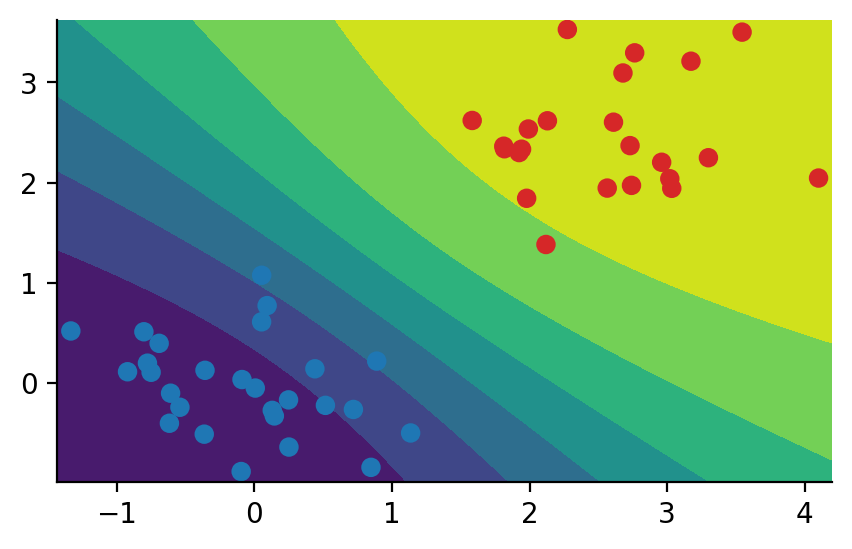

In [500]:
Z_mcmc = sigmoid(jnp.einsum("mij,sm->sij", Phispace, chains))
Z_mcmc = Z_mcmc.mean(axis=0)

plt.contourf(*Xspace, Z_mcmc)
plt.scatter(*X.T, c=colors)
plt.show()

## Assumed Density Filtering (ADF)

In [501]:
mu_t = jnp.zeros(M)
tau_t = jnp.ones(M) * init_noise

w_prior = w0.copy()

# one-step-ahead predictive density
mu_t_cond = mu_t.copy()
tau_t_cond = tau_t + jnp.ones(M) * alpha

# prior predictive distribution
m_t_cond = (Phi[0] * mu_t_cond).sum()
v_t_cond = (Phi[0] ** 2 * tau_t_cond).sum()

In [610]:
def Zt_func(eta, y, mu, v):
    log_term = y * log_sigmoid(eta) + (1 - y) * np.log(1 - sigmoid(eta))
    log_term = log_term - (eta -  mu) ** 2 / (2 * v ** 2)
    
    return np.exp(log_term) / np.sqrt(2 * np.pi * v ** 2)

def mt_func(eta, y, mu, v):
    log_term = y * log_sigmoid(eta) + (1 - y) * np.log(1 - sigmoid(eta))
    log_term = log_term - (eta -  mu) ** 2 / (2 * v ** 2)
    
    return eta * np.exp(log_term) / np.sqrt(2 * np.pi * v ** 2)

def vt_func(eta, y, mu, v):
    log_term = y * log_sigmoid(eta) + (1 - y) * np.log(1 - sigmoid(eta))
    log_term = log_term - (eta -  mu) ** 2 / (2 * v ** 2)
    
    return eta ** 2 * np.exp(log_term) / np.sqrt(2 * np.pi * v ** 2)

In [572]:
%%time
lbound, ubound = -8, 8
Zt, _ = quad(lambda eta: Zt_func(eta, y[0], m_t_cond, v_t_cond), lbound, ubound)

mt, _ = quad(lambda eta: mt_func(eta, y[0], m_t_cond, v_t_cond), lbound, ubound)
mt = mt / Zt

vt, _ = quad(lambda eta: vt_func(eta, y[0], m_t_cond, v_t_cond), lbound, ubound)
vt = vt / Zt - mt ** 2

CPU times: user 229 ms, sys: 55.2 ms, total: 285 ms
Wall time: 224 ms


In [573]:
Zt, mt, vt

(0.045766560455085065, -0.0022309343732053754, 21.323747946248265)

In [574]:
from probnum.quad import bayesquad

In [600]:
%%time
lbound, ubound = -8, 8

Zt, _ = bayesquad(lambda eta: Zt_func(eta, y[0], m_t_cond, v_t_cond), 1, domain=np.array([lbound, ubound]))
Zt = Zt.mean.item()

mt, _ = bayesquad(lambda eta: mt_func(eta, y[0], m_t_cond, v_t_cond), 1, domain=np.array([lbound, ubound]))
mt = mt.mean / Zt

vt, _ = bayesquad(lambda eta: vt_func(eta, y[0], m_t_cond, v_t_cond), 1, domain=np.array([lbound, ubound]))
vt = vt.mean / Zt - mt ** 2

CPU times: user 20.9 ms, sys: 1.03 ms, total: 21.9 ms
Wall time: 17 ms


In [601]:
delta_m = mt - m_t_cond
delta_v = vt - v_t_cond

a = Phi[0] * tau_t_cond / jnp.power(Phi[0] * tau_t_cond, 2).sum()
mu_t = mu_t_cond + a * delta_m
tau_t = tau_t_cond + a ** 2 * delta_v

## All together

In [621]:
q = 0.4
mu_t = w0.copy()
tau_t = jnp.ones(M) * q


lbound, ubound = -10, 10
for t in range(n_datapoints):
    # one-step-ahead predictive density
    mu_t_cond = mu_t.copy()
    tau_t_cond = tau_t.copy() + q

    # prior predictive distribution
    m_t_cond = (Phi[t] * mu_t_cond).sum()
    v_t_cond = (Phi[t] ** 2 * tau_t_cond).sum()

    v_t_cond_sqrt = np.sqrt(v_t_cond)

    Zt, _ = bayesquad(lambda eta: Zt_func(eta, y[t], m_t_cond, v_t_cond_sqrt),
                      1, domain=np.array([lbound, ubound]))
    Zt = Zt.mean

    mt, _ = bayesquad(lambda eta: mt_func(eta, y[t], m_t_cond, v_t_cond_sqrt),
                      1, domain=np.array([lbound, ubound]))
    mt = mt.mean / Zt

    vt, _ = bayesquad(lambda eta: vt_func(eta, y[t], m_t_cond, v_t_cond_sqrt),
                      1, domain=np.array([lbound, ubound]))
    vt = vt.mean / Zt - mt ** 2
    
    delta_m = mt - m_t_cond
    delta_v = vt - v_t_cond

    a = Phi[t] * tau_t_cond / jnp.power(Phi[t] * tau_t_cond, 2).sum()
    mu_t = mu_t_cond + a * delta_m
    tau_t = tau_t_cond + a ** 2 * delta_v

In [622]:
# Adf weights-mean
mu_t

DeviceArray([-2.752284 ,  1.4491423,  0.9128473], dtype=float32)

In [623]:
# mcmc weights-mean
chains.mean(axis=0)

DeviceArray([-2.2755265,  1.2831217,  1.3202051], dtype=float32)

In [624]:
key = random.PRNGKey(314)
adf_samples = random.multivariate_normal(key, mu_t, jnp.diag(tau_t), (5000,))

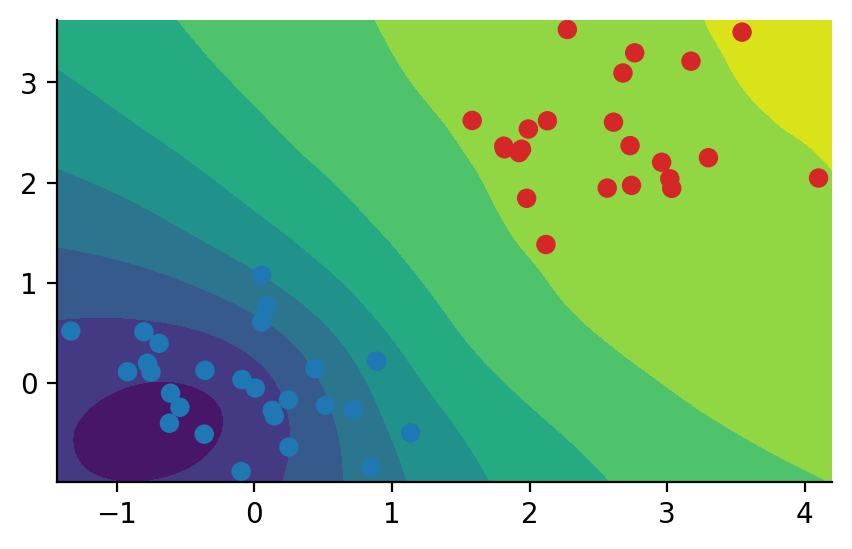

In [625]:
Z_adf = sigmoid(jnp.einsum("mij,sm->sij", Phispace, adf_samples))
Z_adf = Z_adf.mean(axis=0)

plt.contourf(*Xspace, Z_adf)
plt.scatter(*X.T, c=colors)
plt.show()

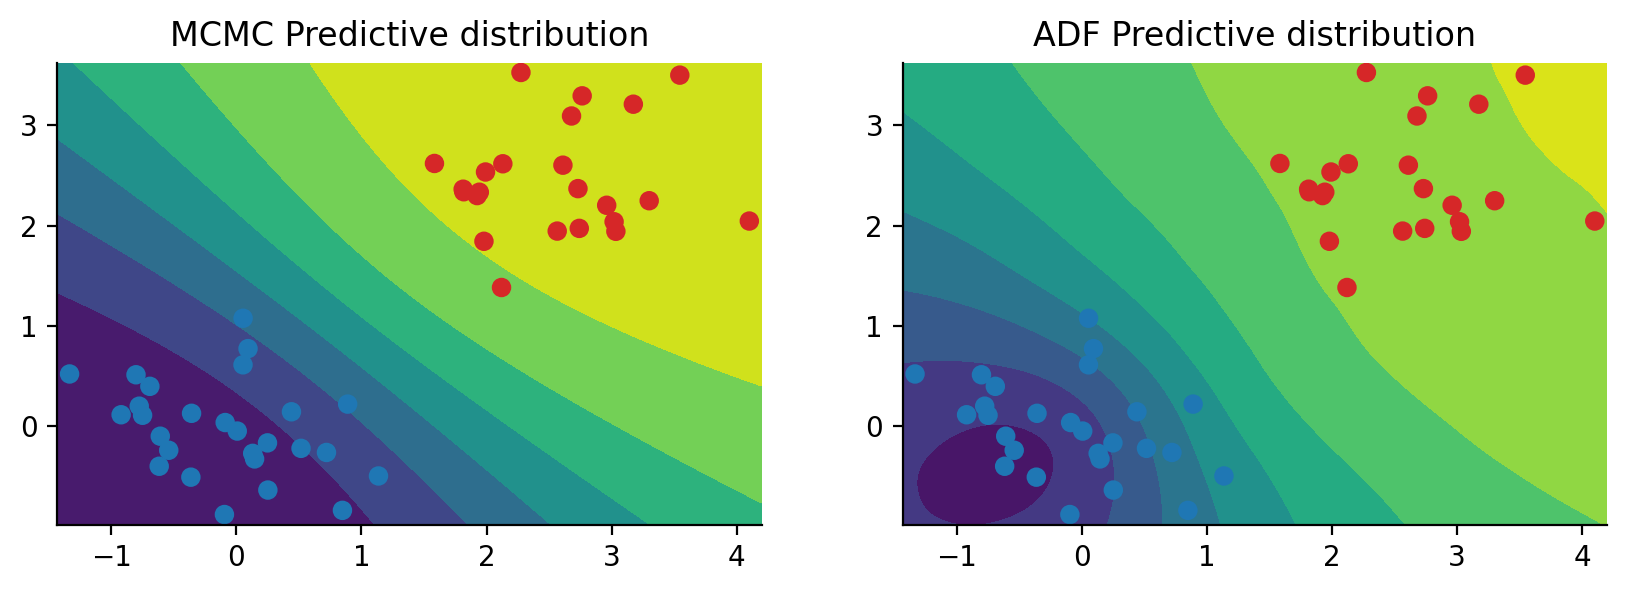

In [626]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))

ax[0].contourf(*Xspace, Z_mcmc)
ax[0].scatter(*X.T, c=colors)
ax[0].set_title("MCMC Predictive distribution")

ax[1].contourf(*Xspace, Z_adf)
ax[1].scatter(*X.T, c=colors)
ax[1].set_title("ADF Predictive distribution")

plt.show()